Basic imports


In [16]:
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, SentencesDataset, losses, models
from sentence_transformers.evaluation import LabelAccuracyEvaluator
from sentence_transformers.readers import InputExample

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import math


Assign device to our GPU if possible (highly recommended!)


In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device


'cuda:0'

Read in our training and testing data, then create our SBert model. We're using distiluse-base-multilingual-cased-v2 as it is trained to work with 50+ languages. It's a little less accurate than some other models, but those models don't support all the languages in our dataset. We'll also add a pooling layer to output a constant 768 layers, independent of input size. Lastly, we'll tack on a dense layer that runs the `tanh()` activation function. We set our epochs to 20 (this may be too high actually) and our batch size to 16, as this is Bert's recommended batch size.


In [3]:
trainRaw = pd.read_csv("train.csv")
testRaw = pd.read_csv("test.csv")
embed_model = models.Transformer(
    "sentence-transformers/distiluse-base-multilingual-cased-v2",
    max_seq_length=256,
    do_lower_case=False,
)
pool_model = models.Pooling(word_embedding_dimension=768)
dense_model = models.Dense(
    in_features=768, out_features=512, activation_function=torch.nn.Tanh()
)
model = SentenceTransformer(modules=[embed_model, pool_model, dense_model])
epochs = 20
batch_size = 16


Let's take a quick look at our dataset, just to make sure everything was brought in correctly.


In [4]:
trainRaw.head()


,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


Now we'll split this data into training, validation, and test sets for use in our neural net later on.


In [5]:
training, validation, testing = np.split(
    trainRaw.sample(frac=1), [int(0.6 * len(trainRaw)), int(0.8 * len(trainRaw))]
)


Let's make sure we have an even split of all labels in each set so we aren't under-training or under-testing on any category.


In [6]:
training["label"].value_counts() / len(training), validation[
    "label"
].value_counts() / len(validation), testing["label"].value_counts() / len(testing)


(0    0.347222
 2    0.334296
 1    0.318482
 Name: label, dtype: float64,
 2    0.344059
 0    0.335809
 1    0.320132
 Name: label, dtype: float64,
 0    0.345297
 2    0.329620
 1    0.325083
 Name: label, dtype: float64)

Now we'll take the split data and turn it into `InputExample`s holding the premise, hypothesis, and the label. This is what will allow SBert to recognize the inputs correctly so it can actually train itself.


In [7]:
training_data = [
    InputExample(texts=[i["premise"], i["hypothesis"]], label=i["label"])
    for _, i in training.iterrows()
]
validation_data = [
    InputExample(texts=[i["premise"], i["hypothesis"]], label=i["label"])
    for _, i in validation.iterrows()
]
testing_data = [
    InputExample(texts=[i["premise"], i["hypothesis"]], label=i["label"])
    for _, i in testing.iterrows()
]
train_dataset = SentencesDataset(training_data, model)


Now we create a couple `DataLoader`s to assist in GPU memory utilization, so we don't have to feed the entire dataset into memory ahead of time.

We'll also define our loss function to be SoftmaxLoss and our evaluator to be LabelAccuracyEvaluator. These are relatively basic models and as such will probably not train as well as more advanced loss models (like MNR).


In [8]:
train_dataloader = DataLoader(training_data, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)
train_loss = losses.SoftmaxLoss(
    model=model,
    sentence_embedding_dimension=model.get_sentence_embedding_dimension(),
    num_labels=3,
)
evaluator = LabelAccuracyEvaluator(
    val_dataloader, softmax_model=train_loss, name="validation_data"
)


We'll use a smaller learning rate for the first couple steps, just to make sure our model doesn't instantly overfit.


In [9]:
warmup_steps = math.ceil(len(train_dataloader) * epochs * 0.1)


Throw the model onto the GPU (or CPU, but again, not recommended).


In [10]:
model = model.to(device=device)


Time to train!


In [11]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=epochs,
    evaluation_steps=1000,
    warmup_steps=warmup_steps,
    output_path="./bert-output",
)


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Iteration:   0%|          | 0/455 [00:00<?, ?it/s]

Now we'll throw our test data at the trained model to see how well we're doing.


In [12]:
test_dataloader = DataLoader(testing_data, shuffle=False, batch_size=batch_size)
test_evaluator = LabelAccuracyEvaluator(
    test_dataloader, softmax_model=train_loss, name="testing_data"
)
test_evaluator(model, output_path="./bert-output")


0.4405940594059406

45% accuracy isn't terrible, but it's certainly not great. Oh well. Let's take a quick look at our validation loss over time to get an idea of what's going on.

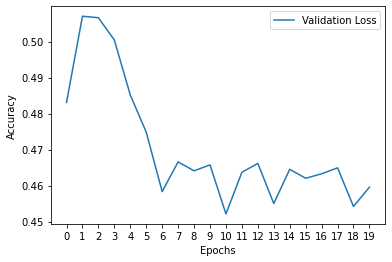

In [35]:
val_loss = pd.read_csv('./bert-output/eval/accuracy_evaluation_validation_data_results.csv')
fig, ax = plt.subplots()
ax.plot(val_loss['epoch'], val_loss['accuracy'], label="Validation Loss")
ax.legend()
ax.set(xlim=(-1,20), xticks=np.arange(20))
ax.set(xlabel="Epochs", ylabel="Accuracy")
plt.show()